# Create a recommendation engine with the recommended dataset

In [1]:
import pandas as pd
import io
import requests
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

Data source : https://www.kaggle.com/netflix-inc/netflix-prize-data
Due to large dataset, only load first 100,000 rows from each data files

In [4]:
def readFile(file_path, rows=100000):
    data_dict = {'Cust_Id' : [], 'Movie_Id' : [], 'Rating' : [], 'Date' : []}
    f = open(file_path, "r")
    count = 0
    for line in f:
        count += 1
        if count > rows:
            break
            
        if ':' in line:
            movidId = line[:-2] # remove the last character ':'
            movieId = int(movidId)
        else:
            customerID, rating, date = line.split(',')
            data_dict['Cust_Id'].append(customerID)
            data_dict['Movie_Id'].append(movieId)
            data_dict['Rating'].append(rating)
            data_dict['Date'].append(date.rstrip("\n"))
    f.close()
            
    return pd.DataFrame(data_dict)
df1 = readFile('./data/combined_data_1.txt', rows=100000)
df2 = readFile('./data/combined_data_2.txt', rows=100000)
df3 = readFile('./data/combined_data_3.txt', rows=100000)
df4 = readFile('./data/combined_data_4.txt', rows=100000)
df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

In [5]:
df = df1.copy()
df = df.append(df2)
df = df.append(df3)
df = df.append(df4)
df.index = np.arange(0,len(df))
df.head(10)

,Cust_Id,Movie_Id,Rating,Date
0,1488844,1,3.0,2005-09-06
1,822109,1,5.0,2005-05-13
2,885013,1,4.0,2005-10-19
3,30878,1,4.0,2005-12-26
4,823519,1,3.0,2004-05-03
5,893988,1,3.0,2005-11-17
6,124105,1,4.0,2004-08-05
7,1248029,1,3.0,2004-04-22
8,1842128,1,4.0,2004-05-09
9,2238063,1,3.0,2005-05-11


In [6]:
print(df.shape)

(399899, 4)


In [7]:
cust_ids = df["Cust_Id"].unique().tolist()
cust2cust_encoded = {x: i for i, x in enumerate(cust_ids)}
custencoded2cust = {i: x for i, x in enumerate(cust_ids)}
movie_ids = df["Movie_Id"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["customer"] = df["Cust_Id"].map(cust2cust_encoded)
df["movie"] = df["Movie_Id"].map(movie2movie_encoded)

num_cust = len(cust2cust_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["Rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of customers: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_cust, num_movies, min_rating, max_rating
    )
)

Number of customers: 172421, Number of Movies: 101, Min rating: 1.0, Max rating: 5.0


In [8]:
df = df.sample(frac=1, random_state=42)
x = df[["customer", "movie"]].values

# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [12]:
x

array([[ 61454,     59],
       [135157,     71],
       [ 33259,     95],
       ...,
       [ 98835,     36],
       [ 87612,     39],
       [ 33931,     36]], dtype=int64)

In [13]:
y

array([0.25, 0.75, 1.  , ..., 0.75, 0.25, 0.75])

# Keras

In [7]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_cust, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_cust = num_cust
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.cust_embedding = layers.Embedding(
            num_cust,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.cust_bias = layers.Embedding(num_cust, 1)
        
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        cust_vector = self.cust_embedding(inputs[:, 0])
        cust_bias = self.cust_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_cust_movie = tf.tensordot(cust_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_cust_movie + cust_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_cust, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

C:\Users\kexin_lee\Anaconda3\envs\python-dscourse\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
5624/5624 [==============================] - 339s 60ms/step - loss: 0.6498 - val_loss: 0.6478
Epoch 2/10
5624/5624 [==============================] - 335s 60ms/step - loss: 0.6446 - val_loss: 0.6455
Epoch 3/10
5624/5624 [==============================] - 347s 62ms/step - loss: 0.6341 - val_loss: 0.6422
Epoch 4/10
5624/5624 [==============================] - 343s 61ms/step - loss: 0.6267 - val_loss: 0.6402
Epoch 5/10
5624/5624 [==============================] - 347s 62ms/step - loss: 0.6211 - val_loss: 0.6392
Epoch 6/10
5624/5624 [==============================] - 339s 60ms/step - loss: 0.6162 - val_loss: 0.6385
Epoch 7/10
5624/5624 [==============================] - 340s 60ms/step - loss: 0.6120 - val_loss: 0.6381
Epoch 8/10
5624/5624 [==============================] - 334s 59ms/step - loss: 0.6082 - val_loss: 0.6381
Epoch 9/10
5624/5624 [==============================] - 344s 61ms/step - loss: 0.6049 - val_loss: 0.6380
Epoch 10/10
5624/5624 [==============================] 

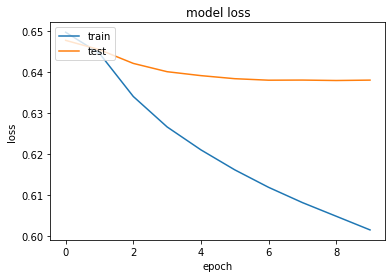

In [9]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [10]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8621050   
                                                                 
 embedding_1 (Embedding)     multiple                  172421    
                                                                 
 embedding_2 (Embedding)     multiple                  5050      
                                                                 
 embedding_3 (Embedding)     multiple                  101       
                                                                 
Total params: 8,798,622
Trainable params: 8,798,622
Non-trainable params: 0
_________________________________________________________________


In [25]:
movie_df = pd.read_csv('./data/movie_titles.csv', encoding= 'unicode_escape')

# Let us get a user and see the top recommendations.
cust_id = df.Cust_Id.sample(1).iloc[0]
movies_watched_by_user = df[df.Cust_Id == cust_id]
movies_not_watched = movie_df[
    ~movie_df["Movie_Id"].isin(movies_watched_by_user.Movie_Id.values)
]["Movie_Id"]

# make the movie not watched by the user into a list
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

# encode the list
cust_encoder = cust2cust_encoded.get(cust_id)
cust_movie_array = np.hstack(
    ([[cust_encoder]] * len(movies_not_watched), movies_not_watched)
)

# fit into prediction
ratings = model.predict(cust_movie_array).flatten()

# sorting
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(cust_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .Movie_Id.values
)
movie_df_rows = movie_df[movie_df["Movie_Id"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.year)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["Movie_Id"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.year)

Showing recommendations for user: 570932
Movies with high ratings from user
--------------------------------
Immortal Beloved : 1994.0
Something's Gotta Give : 2003.0
Breakfast at Tiffany's : 1961.0
The Best Man : 1999.0
If These Walls Could Talk 2 : 2000.0
--------------------------------
Top 10 movie recommendations
--------------------------------
Lord of the Rings: The Return of the King: Extended Edition: Bonus Material : 2003.0
Inspector Morse 31: Death Is Now My Neighbour : 1997.0
Star Trek: The Original Series: Vols. 1-15 : 1966.0
Little House on the Prairie: Season 4 : 1977.0
Saturday Night Live: Christmas : 1999.0
Wire in the Blood: Justice Painted Blind : 2002.0
Independent's Day : 1998.0
Sailor Moon S : 1994.0
South Park: Season 2 : 1998.0
Stray Dog : 1949.0
